# Amazon Fine Food Reviews Analysis

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
1.Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

2.T-SNE visualization of Amazon reviews with polarity based color-coding (that means predicting wheater review is positive or not)

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


## [1.1]Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\ShivamOO7\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_amz_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition_positive_negative(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_amz_data['Score']
positiveNegative = actualScore.map(partition_positive_negative) 
filtered_amz_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_amz_data.shape)
filtered_amz_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
sample_amz_data = filtered_amz_data.head(8000) #Sampled amazon fine foood reviews filtered data to 5k datapoints for time effiecieny

#  Exploratory Data Analysis

## [1.2]Data Cleaning: Deduplication

In [5]:
#Sorting data according to ProductId in ascending order; sorting is necessary because if duplicates entries are there than we want to have only one of it and that we get from first entry of duplicates entries after sorting

sorted_data = sample_amz_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [7]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
# It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator 
#which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(sorted_data.shape)
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(8000, 10)
(7975, 10)


1    6658
0    1317
Name: Score, dtype: int64

<b>Objervation:-</b>As we can see that in sorted_data there are 5k points but now after removing duplicates entries we get some 4.9k points.

## [1.3]Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews.

In [9]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [10]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 15k sentences.
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8') #snoball stemmer
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f: # 'wb' instead 'w' for binary file
        pickle.dump(all_positive_words, f)      # dump data to f
    with open('negitive_words.pkl', 'wb') as f: # 'wb' instead 'w' for binary file
        pickle.dump(all_negative_words, f)      # dump data to f

100%|█████████████████████████████████████| 7975/7975 [00:15<00:00, 499.02it/s]


In [11]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

## [2]Text feature extraction

Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length.

We call vectorization the general process of turning a collection of text documents into numerical feature vectors.

## Techniques for vectorization :--

## [2.1] Bag of Words (BoW)

In [12]:
l=final['Score'] #taking postive/negative reviews labels
labels = l.head(5000) # and sampling only 5k labels

print("the shape of sample data = ", final['Text'].shape)

the shape of sample data =  (7975,)


### [2.1.1] Uni-gram BOW

In [13]:
#BoW
uni_gram_vect = CountVectorizer() #in scikit-learn
uni_gram_counts = uni_gram_vect.fit_transform(final['Text'].values)
print("the type of count vectorizer ",type(uni_gram_counts))
print("the shape of out text BOW vectorizer ",uni_gram_counts.get_shape())
print("the number of unique words ", uni_gram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (7975, 17091)
the number of unique words  17091


### Standardizing the Data 

In [14]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import MaxAbsScaler
standardized_data = MaxAbsScaler().fit_transform(uni_gram_counts).todense()
print(standardized_data.shape)

(7975, 17091)


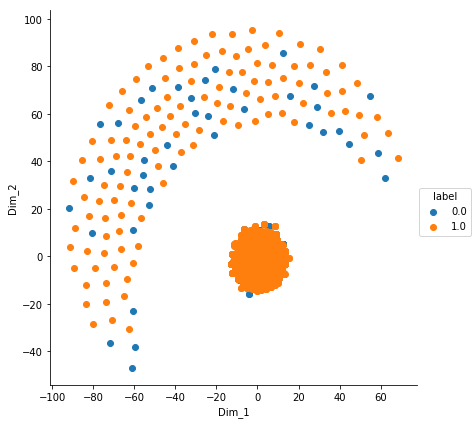

In [15]:
# TSNE
import seaborn as sn
from sklearn.manifold import TSNE
from time import time

# Picking the top 2k points as TSNE takes a lot of time for 15K points
data_2000 = standardized_data[0:2000,:]
labels_2000 = labels[0:2000]

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

### [2.1.2] Bi-gram Bow

In [52]:
#taking one word and two consecutive words together
bi_gram_vect = CountVectorizer(ngram_range=(1,2))
bi_gram_counts = bi_gram_vect.fit_transform(final['Text'].values)
print("the type of count vectorizer ",type(bi_gram_counts))
print("the shape of out text BOW vectorizer ",bi_gram_counts.get_shape())
print("the number of unique words ", bi_gram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 148211)
the number of unique words  148211


### Standardizing the data

In [55]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import MaxAbsScaler
standardized_data_bi = MaxAbsScaler().fit_transform(bi_gram_counts).todense()
print(standardized_data_bi.shape)

(4986, 148211)


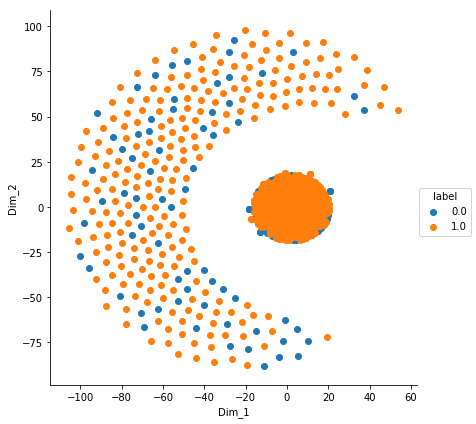

In [56]:
# TSNE
import seaborn as sn
from sklearn.manifold import TSNE
from time import time

# Picking the top 2k points as TSNE takes a lot of time for 15K points
data_2000 = standardized_data_bi[0:2000,:]
labels_2000 = labels[0:2000]

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data_bi = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data_bi = np.vstack((tsne_data_bi.T, labels_2000)).T
tsne_df_bi = pd.DataFrame(data=tsne_data_bi, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df_bi, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

### Observations :-

1. We observe in this t-sne plot that on taking 2k datapoints, both class label(positive class and negative class) data points     are not that much clearly separable by which we cannot make model to classify both class datapoints.

2. And we also see that lot of data points of both classes between interval -20 to +25 are most of them overlapped.

3. Between interval -100 to +60 on x-axis lot of orange points(positive class datapoints) are distibuted in C-shaped structure     and few blue points(negative class datapoints) are spreaded amoung orange points that means very difficult to separate those     points to make classification easier.

# (2) TF-IDF

In [75]:
d=final['Text']
data_tfidf=d.head(5000)

In [82]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1))
final_tf_idf = tf_idf_vect.fit_transform(data_tfidf)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 13510)
the number of unique words including both unigrams and bigrams  13510


In [83]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import MaxAbsScaler
standardized_data_tfidf = MaxAbsScaler().fit_transform(final_tf_idf).todense()
print(standardized_data_tfidf.shape)

(4986, 13510)


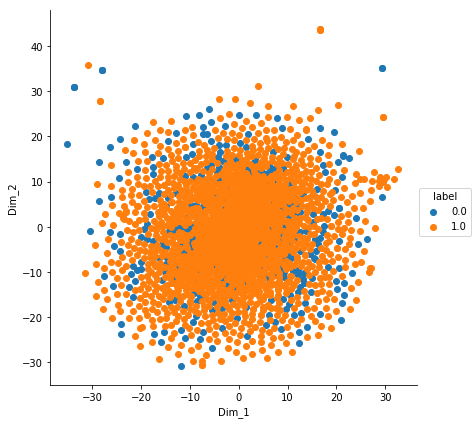

In [84]:
# TSNE
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Picking the top 2k points as TSNE takes a lot of time for 5K points
data_2000 = standardized_data_tfidf[0:2000,:]
labels_2000 = labels[0:2000]

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data_tfidf = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data_tfidf = np.vstack((tsne_data_tfidf.T, labels_2000)).T
tsne_df_tfidf = pd.DataFrame(data=tsne_data_tfidf, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df_tfidf, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

### Observation:- 

1. As we have sampled dataset to only 5k points as on taking whole 15k points(already sampled) it takes lot of time in computation and for making t-sne plot we have taken only 2k points from 5k points beacuse of same reason taking lot of time in computation.
2. We observe in this t-sne plot that on taking 2k datapoints, both class label(positive class and negative class) data points are not that much clearly separable by which we cannot make model to classify both class datapoints.
3. And we also see that lot of data points of both classes between interval -30 to +30 are most of them overlapped.

# (3) Average word2Vec

In [94]:
d=final['Text']
data_avgw2v=d.head(5000)

In [86]:
# Train our own Word2Vec model using our own text corpus
import gensim
i=0
list_of_sent=[]
for sent in data_avgw2v:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [87]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=1,size=50, workers=4)    
# min_count here says that if a word doesn't occur atleast 5 times than not construct its word2vector
# size means dimension of each vector of word  , here is 50 dimension

In [88]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [89]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import MaxAbsScaler
standardized_data_w2v = MaxAbsScaler().fit_transform(sent_vectors)
print(standardized_data_w2v.shape)

(4986, 50)


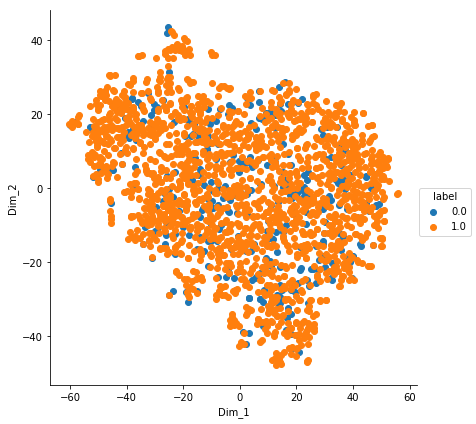

In [90]:
# TSNE
import seaborn as sn
from sklearn.manifold import TSNE

# Picking the top 2k points as TSNE takes a lot of time for 15K points
data_2000 = standardized_data_w2v[0:2000,:]
labels_2000 = labels[0:2000]

model = TSNE(n_components=2, random_state=0)

tsne_data_w2v = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data_w2v = np.vstack((tsne_data_w2v.T, labels_2000)).T
tsne_df_w2v = pd.DataFrame(data=tsne_data_w2v, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df_w2v, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

### Observatons :- 

1. We observe in this t-sne plot that on taking 2k datapoints, both class label(positive class and negative class) data points are not that much clearly separable by which we cannot make model to classify both class datapoints.
2. And we also see that lot here is huge amount of data points of both classes between interval -60 to +60 on x-axis and -40 to +40 on y-axis are most of them overlapped.
3. There by making it very diffcult in this case to classify probelm as most of the points of both class are overlapped and most of blue points are spreaded in between of orange points as randomly spreaded.

# TF-IDF Weighted Word2Vec

In [91]:
# TF-IDF weighted Word2Vec

t=tf_idf_vect.get_feature_names()  # tfidf words/col-names

# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

t1=list()   # the tfidf-w2v for each sentence/review is stored in this list
r=0
for st in list_of_sent:  # for each review/sentence
    sv=np.zeros(50)      # as word vectors are of zero length
    ws=0;                # num of words with a valid vector in the sentence/review
    for wr in st:        # for each word in a review/sentence
        try:
            v=w2v_model.wv[wr]
            tfi=final_tf_idf[r,t.index(wr)]   # obtain the tf_idfidf of a word in a sentence/review
            sv += (v*tfi)
            ws += tfi
        except:
            pass
    sv /= ws
    t1.append(sv)
    r +=1

In [92]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import MaxAbsScaler
standardized_data_tfidfw2v = MaxAbsScaler().fit_transform(t1)
print(standardized_data_tfidfw2v.shape)

(4986, 50)


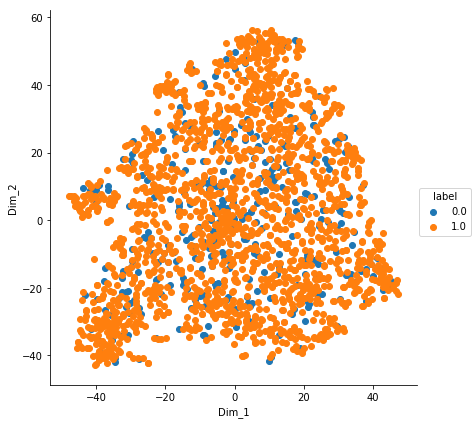

In [93]:
# TSNE
import seaborn as sn
from sklearn.manifold import TSNE

# Picking the top 2k points as TSNE takes a lot of time for 15K points
data_2000 = standardized_data_tfidfw2v[0:2000,:]
labels_2000 = labels[0:2000]

model = TSNE(n_components=2, random_state=0)

tsne_data_tfidfw2v = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data_tfidfw2v = np.vstack((tsne_data_tfidfw2v.T, labels_2000)).T
tsne_df_tfidfw2v = pd.DataFrame(data=tsne_data_tfidfw2v, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df_tfidfw2v, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

### Observations :-

1. We observe in this t-sne plot that on taking 2k datapoints, both class label(positive class and negative class) data points are not that much clearly separable by which we cannot make model to classify both class datapoints.
2. And we also see that lot here is huge amount of data points of both classes between interval -40 to +40 on x-axis and -40 to +60 on y-axis are most of them overlapped.
3. There by making it very diffcult in this case to classify probelm as most of the points of both class are overlapped and most of blue points are spreaded in between of orange points as randomly spreaded.

## Final Observations :-  

As we have seen all four techniques for featurization/vetorization (Bow, tf-idf, avg-word2vec, tf-idf weighted word2vec) neither of them can separate data points as clearlt as it is needed to bulid our classification model for this Amazon fine food review dataset